In [104]:
import torch.nn as nn

import xarray as xr
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchsummary import summary

In [105]:
data_120 = xr.open_dataset('data/camx120hr_merged_20230717.nc')

data_96= xr.open_dataset('data/camxmet2d.delhi.20230717.96hours.nc')

In [106]:
data_120

<xarray.Dataset>
Dimensions:  (TSTEP: 120, LAY: 1, ROW: 80, COL: 80, VAR: 9, DATE-TIME: 2)
Dimensions without coordinates: TSTEP, LAY, ROW, COL, VAR, DATE-TIME
Data variables:
    P10      (TSTEP, LAY, ROW, COL) float32 ...
    P25      (TSTEP, LAY, ROW, COL) float32 ...
    TFLAG    (TSTEP, VAR, DATE-TIME) int32 ...
Attributes: (12/34)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2023197
    CTIME:          83911
    WDATE:          2023197
    ...             ...
    GDNAM:          ????????????????
    UPNAM:          CAMXMETOU       
    VAR-LIST:       P10             P25             
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    HISTORY:        Mon Jul 17 08:45:22 2023: ncrcat camxout.2023.07.16.nc ca...
    NCO:            netCDF Operators version 4.9.1 (Homepage = http://nco.sf....

In [107]:
data_96

<xarray.Dataset>
Dimensions:     (TSTEP: 96, VAR: 14, DATE-TIME: 2, LAY: 1, ROW: 80, COL: 80)
Dimensions without coordinates: TSTEP, VAR, DATE-TIME, LAY, ROW, COL
Data variables: (12/15)
    TFLAG       (TSTEP, VAR, DATE-TIME) int32 ...
    TSURF_K     (TSTEP, LAY, ROW, COL) float32 ...
    SNOWEW_M    (TSTEP, LAY, ROW, COL) float32 ...
    SNOWAGE_HR  (TSTEP, LAY, ROW, COL) float32 ...
    PRATE_MMpH  (TSTEP, LAY, ROW, COL) float32 ...
    CLOUD_OD    (TSTEP, LAY, ROW, COL) float32 ...
    ...          ...
    SWSFC_WpM2  (TSTEP, LAY, ROW, COL) float32 ...
    SOLM_M3pM3  (TSTEP, LAY, ROW, COL) float32 ...
    CLDTOP_KM   (TSTEP, LAY, ROW, COL) float32 ...
    CAPE        (TSTEP, LAY, ROW, COL) float32 ...
    PBL_WRF_M   (TSTEP, LAY, ROW, COL) float32 ...
    PBL_YSU_M   (TSTEP, LAY, ROW, COL) float32 ...
Attributes: (12/33)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2023198
    CTIME:          73941
    WDATE:          2023198
    ...             ...
    VGLVLS:         [0. 0.]
    GDNAM:          ????????????????
    UPNAM:          CAMx2IOAPI      
    VAR-LIST:       TSURF_K         SNOWEW_M        SNOWAGE_HR      PRATE_MMp...
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    HISTORY:

In [108]:
# wind speed at hour
X=[]

# corresponding PM25 next hour
y=[]

for i in range(0,95):
    wind_speed = data_96['U10_MpS'][data_96['TSTEP']==i]
    wind_speed= wind_speed[0,:,:]
    wind_speed= wind_speed[0,:,:]
    X.append(wind_speed)
    p25= data_120['P25'][data_120['TSTEP']==i+1+24]
    p25= p25[0,:,:]
    p25= p25[0,:,:]
    y.append(p25)

In [109]:
X=  np.array(X)
y= np.array(y)

In [110]:
print('X shape:', X.shape, 'y shape:', y.shape)

X shape: (95, 80, 80) y shape: (95, 80, 80)


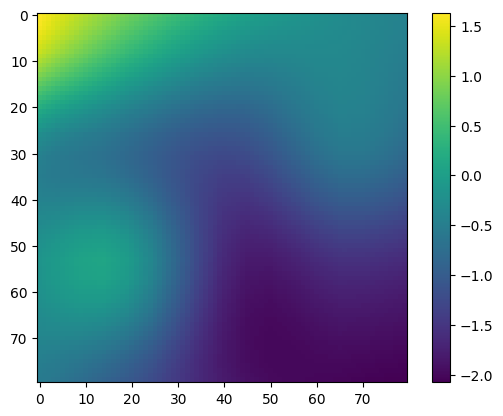

In [111]:
plt.imshow(X[0])
plt.colorbar()

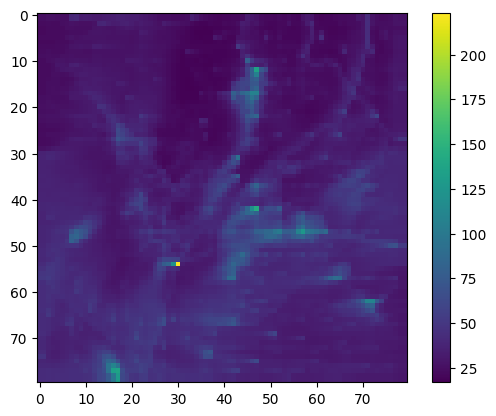

In [112]:
plt.imshow(y[0])
plt.colorbar()

In [113]:
# Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 128, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Adjust padding and output_padding
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # Adjust padding and output_padding
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [114]:
# Initialize model
model = Autoencoder()

summary(model, input_size=(1, 80, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 80, 80]             320
         MaxPool2d-2           [-1, 32, 40, 40]               0
            Conv2d-3          [-1, 128, 40, 40]          36,992
         MaxPool2d-4          [-1, 128, 20, 20]               0
   ConvTranspose2d-5           [-1, 32, 40, 40]          36,896
   ConvTranspose2d-6            [-1, 1, 80, 80]             289
Total params: 74,497
Trainable params: 74,497
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 4.35
Params size (MB): 0.28
Estimated Total Size (MB): 4.65
----------------------------------------------------------------


In [115]:
import torch.utils.data as data

class CustomDataset(data.Dataset):
    def __init__(self, input_data, output_data):
        self.input_data = input_data
        self.output_data = output_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, index):
        input_sample = torch.Tensor(self.input_data[index])
        output_sample = torch.Tensor(self.output_data[index])
        return input_sample, output_sample

In [116]:
custom_dataset = CustomDataset(X, y)

In [117]:
batch_size = 1  # You can adjust the batch size as needed
train_loader = data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

In [118]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20

epochs=[]
losses=[]

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, targets)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print the average loss for this epoch
    average_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {average_loss:.4f}")
    epochs.append(epoch+1)
    losses.append(average_loss)
# Save the trained model if needed
torch.save(model.state_dict(), 'auto_encoder.pth')

Epoch [1/20] Loss: 482.5185
Epoch [2/20] Loss: 265.7598
Epoch [3/20] Loss: 261.5811
Epoch [4/20] Loss: 251.8225
Epoch [5/20] Loss: 253.1408
Epoch [6/20] Loss: 253.5276
Epoch [7/20] Loss: 270.3000
Epoch [8/20] Loss: 275.6503
Epoch [9/20] Loss: 242.1126
Epoch [10/20] Loss: 238.9675
Epoch [11/20] Loss: 244.7633
Epoch [12/20] Loss: 238.7719
Epoch [13/20] Loss: 244.8723
Epoch [14/20] Loss: 238.8580
Epoch [15/20] Loss: 239.6607
Epoch [16/20] Loss: 249.3301
Epoch [17/20] Loss: 253.0043
Epoch [18/20] Loss: 244.9457
Epoch [19/20] Loss: 239.4834
Epoch [20/20] Loss: 251.6982


Text(0, 0.5, 'loss')

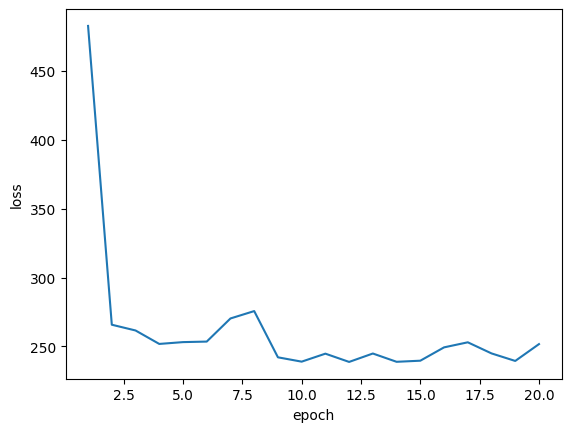

In [119]:
plt.plot(epochs, losses)
plt.xlabel('epoch')
plt.ylabel('loss')


In [120]:
# Test the model on a sample of the test dataset
data_120_test = xr.open_dataset('data/camx120hr_merged_20230718.nc')

data_96_test= xr.open_dataset('data/camxmet2d.delhi.20230718.96hours.nc')

In [131]:
X_test=[]
y_test=[]

wind_speed = data_96_test['U10_MpS'][data_96_test['TSTEP']==10]
wind_speed= wind_speed[0,:,:]
wind_speed= wind_speed[0,:,:]
X_test.append(wind_speed)
p25= data_120_test['P25'][data_120_test['TSTEP']==10]
p25= p25[0,:,:]
p25= p25[0,:,:]
y_test.append(p25)

In [122]:
X_test=  np.array(X_test)
y_test= np.array(y_test)

In [123]:
print('X_test shape:', X_test.shape, 'y_test shape:', y_test.shape)

X_test shape: (1, 80, 80) y_test shape: (1, 80, 80)


In [124]:
# Assuming you have already defined and initialized your model architecture
model = Autoencoder()  # Replace with your model class

# Load the trained model's state dictionary
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [125]:
new_input_tensor = torch.Tensor(X_test[0])
new_input_tensor= new_input_tensor.unsqueeze(0)

In [126]:
new_input_tensor.shape

torch.Size([1, 80, 80])

In [127]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient tracking during inference
    predictions = model(new_input_tensor)

In [128]:
predictions.shape

torch.Size([1, 80, 80])

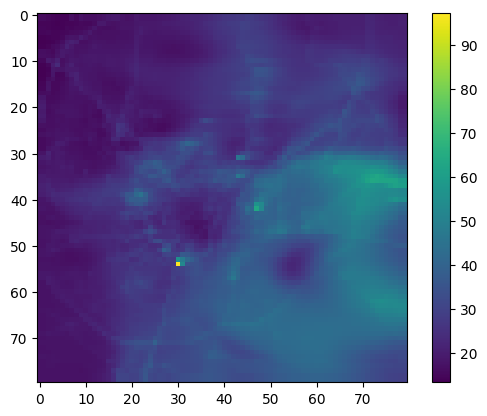

In [129]:
plt.imshow(y_test[0])
plt.colorbar()

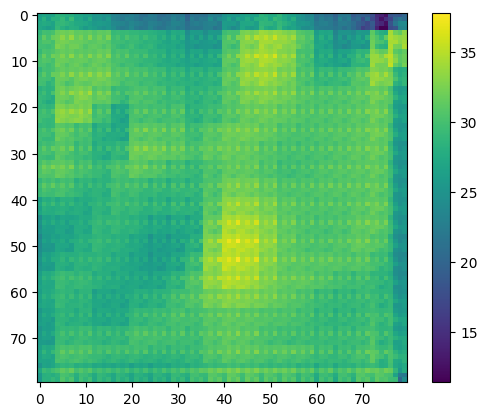

In [130]:
plt.imshow(predictions[0])
plt.colorbar()